In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import mode
from itertools import combinations
from sklearn import svm
import matplotlib.pyplot as plt

class SVMBase:
    def __init__(self, learning_rate=0.001, _lambda=0.01, nb_epoch=1000):
        self.learning_rate = learning_rate
        self._lambda = _lambda
        self.nb_epoch = nb_epoch
        self.W = None
        self.b = None
    def fit_base(self, X, y):
        nb_rows, nb_feature = X.shape
        #Gradiant descent
        self.W = np.zeros(nb_feature)
        self.b = 0

        for _ in range(self.nb_epoch):
            for i in range(nb_rows):
                if y[i]*(np.dot(self.W, X[i]) - self.b) >= 1 :
                    self.W -= self.learning_rate*(2*self._lambda * self.W)
                else:
                    self.W -= self.learning_rate * (2 * self._lambda * self.W - np.dot(X[i], y[i]))
                    self.b -= self.learning_rate * y[i]
    
    def predict_base(self, X):
        output = np.dot(X, self.W) - self.b
        y = np.sign(output)
        return np.where(y == 1, 1, 0)
    
    def decision_base(self, X):
        return np.dot(X, self.W) - self.b
    
class SVM(SVMBase):
    def __init__(self, learning_rate=0.001, _lambda=0.01, nb_epoch=1000, decision='ova'):
        self.learning_rate = learning_rate
        self._lambda = _lambda
        self.nb_epoch = nb_epoch
        self.nb_label = None
        self.decision = decision
        self.classifiers = []
        self.class_pairs = []
        super().__init__(learning_rate=learning_rate, _lambda=_lambda, nb_epoch=nb_epoch)
        
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        labels = np.unique(y)
        self.nb_label = len(labels)
        if self.nb_label == 2:
            y = np.where(y == 0, -1, 1)
            self.fit_base(X, y)
        elif self.decision == 'ova':
            y_list = [np.where(y == label, 1, -1) for label in labels]
            for y_i in y_list:
                svm1 = SVMBase()
                svm1.fit_base(X, y_i)
                self.classifiers.append(svm1)
        elif self.decision == 'ovo':
            print(X.shape)
            self.class_pairs = list(combinations(set(y), 2))
            for class_pair in self.class_pairs:
                indexs = np.where((y == class_pair[0]) | (y == class_pair[1]))
                y_i = np.where(y[indexs] == class_pair[0], 1, -1)
                clf = SVMBase()
                clf.fit_base(X[indexs], y_i)
                self.classifiers.append(clf)
                
    def predict(self, X):
        X = np.array(X)
        if self.nb_label == 2:
            return self.predict_base(X)
        elif self.decision == 'ova':
            return self.predict_multiclass_ova(X)
        elif self.decision == 'ovo':
            return self.predict_multiclass_ovo(X)
        
    def predict_multiclass_ova(self, X):
        predictions = np.zeros((X.shape[0], len(self.classifiers)))
        for idx, clf in enumerate(self.classifiers):
            predictions[:, idx] = clf.decision_base(X)
        # return the argmax of the decision function as suggested by Vapnik.
        return np.argmax(predictions, axis=1)

    def predict_multiclass_ovo(self, X):
        predictions = np.zeros((X.shape[0], len(self.classifiers)))
        for idx, clf in enumerate(self.classifiers):
            class_pair = self.class_pairs[idx]
            prediction = clf.predict_base(X)
            predictions[:, idx] = np.where(prediction == 1, class_pair[0], class_pair[1])
        return mode(predictions, axis=1)[0].ravel().astype(int)
    
    def score(self, y_true, y_predict):
        return np.sum(y_true == y_predict) / len(y_true)
 
    def plot_contours(self, X, y):
        X = np.array(X)
        y = np.array(y)
        # plot the resulting classifier
        h = 0.01
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        points = np.c_[xx.ravel(), yy.ravel()]
        
        if self.nb_label == 2:
            Z = self.predict_base(points)
        elif self.decision == 'ova':
            Z = self.predict_multiclass_ova(points)
        elif self.decision == 'ovo':
            Z = self.predict_multiclass_ovo(points)
            
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

        # plt the points
        plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
        plt.show()
        
        
from sklearn import datasets
#X, y =  datasets.make_blobs(n_samples=50, n_features=2, centers=2, cluster_std=1.05, random_state=40)

iris = datasets.load_iris()
data = pd.DataFrame(iris.data, columns=iris.feature_names)
data["label"] = iris.target
X, y  = data.drop("label", axis=1), data["label"].values



svm = SVM()
svm.fit(X, y)
predictions = svm.predict(X)
score = modele.score(y, predictions)
#modele.plot_contours(X, y)
print(y)
print(predictions)
print(score)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 1 2 2 1 2 1 2 0 1 2 1 2 1 2 1 2 2
 1 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
0.7666666666666667


In [59]:
def load_X(k):
    if k == 0:
        return np.array([[4, 2], [4, 3], [5, 1], [5, 2],
                     [5, 3], [6, 1], [6, 2], [9, 4],
                     [9, 7], [10, 5], [10, 6], [11, 6]])
    else:
        return np.array([[1, 6], [1, 7], [2, 5], [2, 8],
                     [4, 2], [4, 3], [5, 1], [5, 2],
                     [5, 3], [6, 1], [6, 2], [9, 4],
                     [9, 7], [10, 5], [10, 6], [11, 6],
                     [5, 9], [5, 10], [5, 11], [6, 9],
                     [6, 10], [7, 10], [8, 11]])


def load_y(k):
    if k  == 0:
        return np.array([1,1,1,1,1,1,1,0,0,0,0,0])
    else:
        return np.array([1, 1, 1, 1,
                     2, 2, 2, 2, 2, 2, 2,
                     3, 3, 3, 3, 3,
                     4, 4, 4, 4, 4, 4, 4])

X = load_X(0)
y = load_y(0)

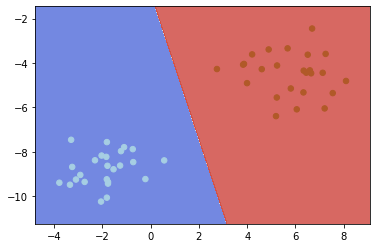

[1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1
 0 1 1 0 0 1 1 1 0 0 1 1 0]
[1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1
 0 1 1 0 0 1 1 1 0 0 1 1 0]
1.0


In [60]:
from sklearn import datasets
X, y =  datasets.make_blobs(n_samples=50, n_features=2, centers=2, cluster_std=1.05, random_state=40)


svm = SVM()
svm.fit(X, y)
predictions = svm.predict(X)
score = modele.score(y, predictions)
modele.plot_contours(X, y)
print(y)
print(predictions)
print(score)

In [64]:
x, y = 2, 4
x

2

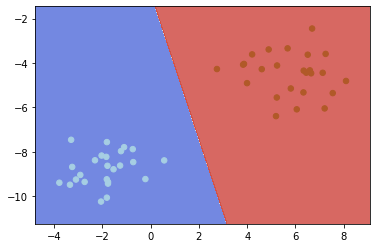

[1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1
 0 1 1 0 0 1 1 1 0 0 1 1 0]
[1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1
 0 1 1 0 0 1 1 1 0 0 1 1 0]
1.0


In [61]:
modele = SVM()

modele.fit(X, y)
predictions = modele.predict(X)
score = modele.score(y, predictions)
modele.plot_contours(X, y)
print(y)
print(predictions)
print(score)

In [ ]:
from sklearn import svm
def SVM_ScikitLearn(X, y, kernel='linear'):
    def plot_contours(X, y, svm):
        # plot the resulting classifier
        h = 0.01
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        points = np.c_[xx.ravel(), yy.ravel()]

        Z = svm.predict(points)
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

        # plt the points
        #plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.coolwarm)
        plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
        plt.show()

    def plot_contour(X, y, classifiers):
        # plot the resulting classifier
        h = 0.01
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        points = np.c_[xx.ravel(), yy.ravel()]

        Z = predict_class(points, classifiers)
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

        # plt the points
        #plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.coolwarm)
        plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
        plt.show()
    def predict_class(X, classifiers):
        predictions = np.zeros((X.shape[0], len(classifiers)))
        for idx, clf in enumerate(classifiers):
            predictions[:, idx] = clf.decision_function(X)
        # return the argmax of the decision function as suggested by Vapnik.
        return np.argmax(predictions, axis=1) + 1
            
    labels = np.unique(y)
    y_list = [np.where(y == label, 1, -1) for label in labels]
    classifiers = []
    for y_i in y_list:
        clf = svm.SVC(kernel='linear', C=1000)
        clf.fit(X, y_i)
        classifiers.append(clf)
        plot_contours(X, y, clf)
    plot_contour(X, y, classifiers)

In [ ]:
SVM_ScikitLearn(X, y)

In [ ]:
X = load_X(1)
y = load_y(1)
# Create datasets.
def predict_classovo(X, classifiers, class_pairs):
    predictions = np.zeros((X.shape[0], len(classifiers)))
    for idx, clf in enumerate(classifiers):
        class_pair = class_pairs[idx]
        prediction = clf.predict(X)
        predictions[:, idx] = np.where(prediction == 1,

                                       class_pair[0], class_pair[1])
    return mode(predictions, axis=1)[0].ravel().astype(int)

def plot_contours(X, y, classifiers, class_pairs):
    # plot the resulting classifier
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    points = np.c_[xx.ravel(), yy.ravel()]

    Z = predict_classovo(points, classifiers, class_pairs)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # plt the points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    plt.show()

In [ ]:
class_pairs = list(combinations(set(y), 2))
classifiers= []
for class_pair in class_pairs:
    indexs = np.where((y == class_pair[0]) | (y == class_pair[1]))
    y_i = np.where(y[indexs] == class_pair[0], 1, -1)
    clf = svm.SVC(kernel='linear', C=1000)
    clf.fit(X[indexs], y_i)
    classifiers.append(clf)
plot_contours(X, y, classifiers, class_pairs)

In [13]:
a=3
if a == 1:
    print("11111")
elif a == 2:
    print("222222")
elif a == 3:
    print("333333")

333333
